In [1]:
# # A fit with BAT.jl
#
# In this example we show how to bring the PDF parametrisation and
# forward model together with `BAT.jl` to perform a fit of simulated data.
# This fit is a work in progress and just a starting point for verification
# of the method.

In [92]:
using BAT, DensityInterface
using PartonDensity
using QCDNUM
using Plots, Random, Distributions, ValueShapes, ParallelProcessingTools
using StatsBase, LinearAlgebra
using SpecialFunctions, Printf
const sf = SpecialFunctions;
using DelimitedFiles
using LaTeXStrings
using HypothesisTests
using Statistics

gr(fmt=:png);

In [3]:
import HDF5
samples = bat_read("/Users/AllenCCaldwell/F2/Dirichlet-DataFit/Data-Dirichlet-sysrun-priors-tight.h5").result
#samples = bat_read("/Users/AllenCCaldwell/F2/Dirichlet-DataFit/Data-Dirichlet-sysrun-priors-long.h5").result

open("report-sysrun-priors-tight.txt", "w") do io
#open("report-sysrun-priors-long.txt", "w") do io
   show(io, MIME"text/plain"(), bat_report(samples))
end

In [4]:
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);
# now SPLINT and quark coefficients
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();
# initialise QCDNUM
#forward_model_init(qcdnum_grid, qcdnum_params, splint_params)
forward_model_init_sysErr(qcdnum_grid, qcdnum_params, splint_params)

0.00019953
0.00016954
0.00019447
1.7525000000000006e-5
1.7525000000000006e-5
1.7525000000000006e-5
0.002478736000000001


In [5]:
#
# The following used just to define arrays
#
pdf_params_gen, sim_data = pd_read_sim("/Users/AllenCCaldwell/F2/Dirichlet-referencefit/simulation-Dirichlet.h5")
nbins=sim_data["nbins"]
counts_obs_ep_sim= sim_data["counts_obs_ep"]
counts_obs_em_sim= sim_data["counts_obs_em"]

#
# Read in the ZEUS data
#
counts_obs_ep_data = readdlm("/Users/AllenCCaldwell/F2/PartonDensity/eP.dat") 
counts_obs_em_data = readdlm("/Users/AllenCCaldwell/F2/PartonDensity/eM.dat") 

153×1 Matrix{Float64}:
 810.0
 589.0
 487.0
 517.0
 399.0
 349.0
 325.0
 904.0
 804.0
 749.0
 622.0
 570.0
 570.0
   ⋮
  80.0
  51.0
  71.0
  49.0
  43.0
  25.0
  11.0
   6.0
   9.0
   2.0
 183.0
  16.0

In [6]:
#
# The prior used in the fitting - should read this from a file
#
#
# The tight prior definition on K_u, K_d
#
prior = NamedTupleDist(
    θ = Dirichlet([34.,17.,22.,22.,2,2,1,1,0.5]),
    K_u = Truncated(Normal(3.5, 0.5), 2., 5.),
    K_d = Truncated(Normal(3.5, 0.5), 2., 5.),
    λ_g1 = Uniform(1., 2.),
    λ_g2 = Uniform(-0.5, -0.1),
    K_g =  Truncated(Normal(4., 1.5), 2., 5.),
    λ_q = Uniform(-0.5, -0.1),
    Beta1 =  Truncated(Normal(0, 1), -5, 5),
    Beta2 =  Truncated(Normal(0, 1), -5, 5),
    beta0_1=  Truncated(Normal(0, 1), -5, 5), 
    beta0_2=   Truncated(Normal(0, 1), -5, 5),    
    beta0_3= Truncated(Normal(0, 1), -5, 5), 
    beta0_4=  Truncated(Normal(0, 1), -5, 5), 
    beta0_5=  Truncated(Normal(0, 1), -5, 5), 
    beta0_6=  Truncated(Normal(0, 1), -5, 5), 
    beta0_7=  Truncated(Normal(0, 1), -5, 5), 
    beta0_8=   Truncated(Normal(0, 1), -5, 5)
);

# The loose prior definition on K_u, K_d
#=
       prior = NamedTupleDist(
           θ = Dirichlet([34.,17.,22.,22.,2,2,1,1,0.5]),
           K_u = Truncated(Normal(3.5, 1.), 2., 5.),
           K_d = Truncated(Normal(3.5, 1.), 2., 5.),
           λ_g1 = Uniform(1., 2.),
           λ_g2 = Uniform(-0.5, -0.1),
           K_g =  Truncated(Normal(4., 1.5), 2., 5.),
           λ_q = Uniform(-0.5, -0.1),
           Beta1 =  Truncated(Normal(0, 1), -5, 5),
           Beta2 =  Truncated(Normal(0, 1), -5, 5),
           beta0_1=  Truncated(Normal(0, 1), -5, 5), 
           beta0_2=   Truncated(Normal(0, 1), -5, 5),    
           beta0_3= Truncated(Normal(0, 1), -5, 5), 
           beta0_4=  Truncated(Normal(0, 1), -5, 5), 
           beta0_5=  Truncated(Normal(0, 1), -5, 5), 
           beta0_6=  Truncated(Normal(0, 1), -5, 5), 
           beta0_7=  Truncated(Normal(0, 1), -5, 5), 
           beta0_8=   Truncated(Normal(0, 1), -5, 5)
       );
=#
# Generate samples according to prior for plotting
priorsamples=bat_sample(prior).result

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/f4aNp/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm IIDSampling
│   nsamples: Int64 100000
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/f4aNp/src/algotypes/bat_default.jl:44


DensitySampleVector, StructArray with 5 columns and 100000 rows:
      v                                        logd     weight  info     aux
    ┌───────────────────────────────────────────────────────────────────────────
 1  │ (θ = [0.327242, 0.143668, 0.186674, 0.…  11.9053  1       nothing  nothing
 2  │ (θ = [0.341367, 0.207959, 0.255735, 0.…  6.60709  1       nothing  nothing
 3  │ (θ = [0.380346, 0.111296, 0.230661, 0.…  11.6548  1       nothing  nothing
 4  │ (θ = [0.331699, 0.223505, 0.199166, 0.…  4.9047   1       nothing  nothing
 5  │ (θ = [0.374045, 0.159626, 0.132657, 0.…  3.81311  1       nothing  nothing
 6  │ (θ = [0.341745, 0.148437, 0.250465, 0.…  8.7305   1       nothing  nothing
 7  │ (θ = [0.351444, 0.138563, 0.118064, 0.…  3.28749  1       nothing  nothing
 8  │ (θ = [0.353341, 0.126155, 0.158795, 0.…  5.41837  1       nothing  nothing
 9  │ (θ = [0.363103, 0.182594, 0.21712, 0.1…  6.05524  1       nothing  nothing
 10 │ (θ = [0.369447, 0.231832, 0.188528, 0.…  7

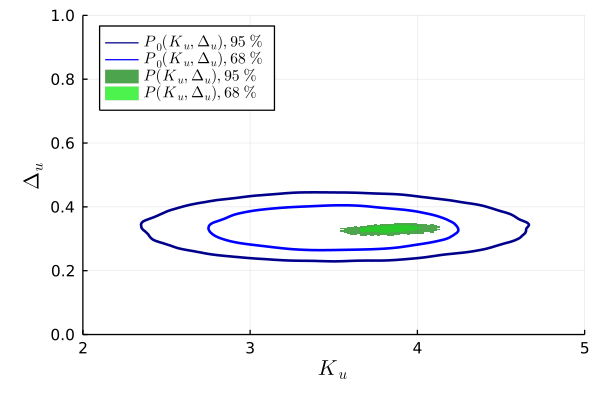

In [47]:
#
# Here we plot a comparison of the prior and posterior contours in the space of K_
plot(
   [NaN], legend = :topleft, linecolor = :blue4,
   label = L"P_0(K_u,\Delta_u), 95~\%")
plot!(priorsamples, (:(K_u), :(θ[1])),xrange=(2.,5),yrange=(0,1),seriestype=:smallest_intervals_contour,linecolor=:blue4,    
intervals = [0.955],smoothing=4,marginalmode = false,
    legend=:topleft,
    label=L"P_0(K_u,\Delta_u), 95~\%",)
plot!(
   [NaN], legend = :topleft, linecolor = :blue,
   label = L"P_0(K_u,\Delta_u), 68~\%")
plot!(priorsamples, (:(K_u), :(θ[1])),xrange=(2.,5),yrange=(0,1),seriestype=:smallest_intervals_contour,linecolor=:blue,    
intervals = [0.68], smoothing=4,marginalmode = false,
    legend=:topleft,
    label=L"P_0(K_u,\Delta_u), 68~\%",)
plot!(
    samples, (:(K_u), :(θ[1])),xrange=(2.,5),yrange=(0,1.),
    intervals = [0.955],
    nbins=100,
    colors=[:green],
    smoothing=4,
    alpha=0.7,
    marginalmode=false,
    legend=:topleft,
    label=L"P(K_u,\Delta_u), 95~\%",
    
)
plot!(
    samples, (:(K_u), :(θ[1])),xrange=(2.,5),yrange=(0,1.),
    intervals = [0.683],
    nbins=100,
    colors=[:green2],
    smoothing=4,
    alpha=0.7,
    marginalmode=false,
    legend=:topleft,
    label=L"P(K_u,\Delta_u), 68~\%",
    xlabel=L"K_u",
    ylabel=L"\Delta_u",
#    legendfontsize=3,
    thickness_scaling=1.3
    
)

In [48]:
savefig("Mom-K.pdf")

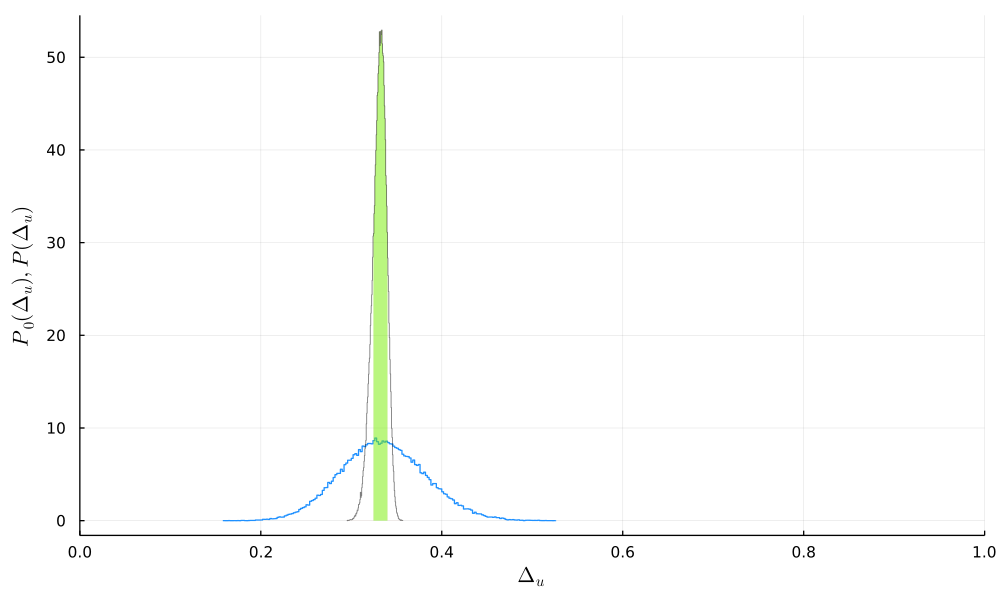

In [44]:
#
# Comparison of prior and posterior for momentum of u-valence
#
p1=plot(priorsamples, vsel=[:(θ[1])],xrange=(0,1),seriestype=:stephist,
        label=L"P_0(\Delta_u)",
)
#=
p1=plot!(samples, vsel=[:(θ[1])],xrange=(0,1),    
    xlabel=L"\Delta_u",
    ylabel=L"P(\Delta_u)",
    label=L"68~\%~{\rm Credible \; Interval",
    thickness_scaling=1.1,
    legend=:topright,
        alpha=0.5,
    intervals = [0.68],
    )
=#
p1=plot!(samples, vsel=[:(θ[1])],xrange=(0,1),    
    xlabel=L"\Delta_u",
    ylabel=L"P_0(\Delta_u), P(\Delta_u)",
    label=L"68~\%~{\rm Credible \; Interval",
    thickness_scaling=1.3,
    legend=:none,
        alpha=0.5,
    intervals = [0.68],
    )
plot(p1)

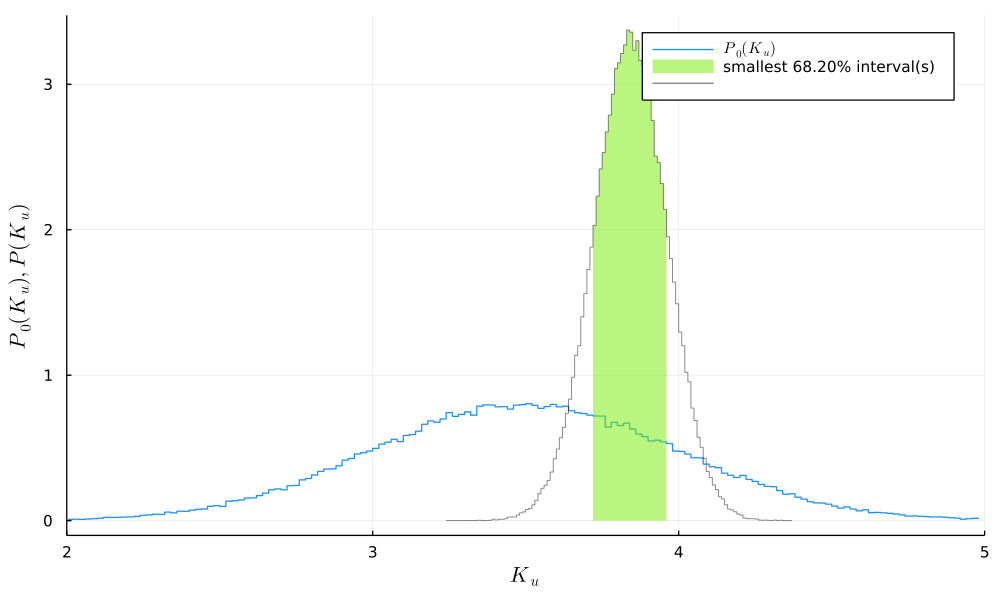

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [100]:
#
# Comparison of prior and posterior for K_u
#
p2=plot(priorsamples, vsel=[:K_u],xrange=(2,5),seriestype=:stephist,
            label=L"P_0(K_u)",
    )
p2=plot!(samples, vsel=[:K_u],xrange=(2,5),    
    xlabel=L"K_u",
    ylabel=L"P_0(K_u), P(K_u)",
    label=L"68~\%~{\rm Credible \; Interval",
    thickness_scaling=1.3,
    legend=:topright,
    alpha=0.5,
    intervals = [0.68],
    )
#plot(p2)

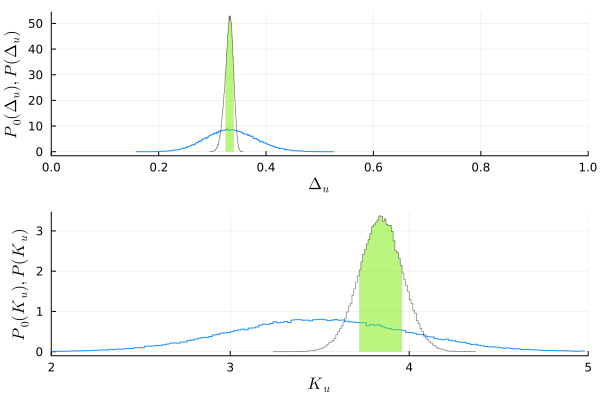

In [30]:
#
# Stacked plots
#
plot(p1,p2, layout = (2, 1))

In [31]:
savefig("Marginals-momu-Ku.pdf")

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/f4aNp/src/algotypes/bat_default.jl:44


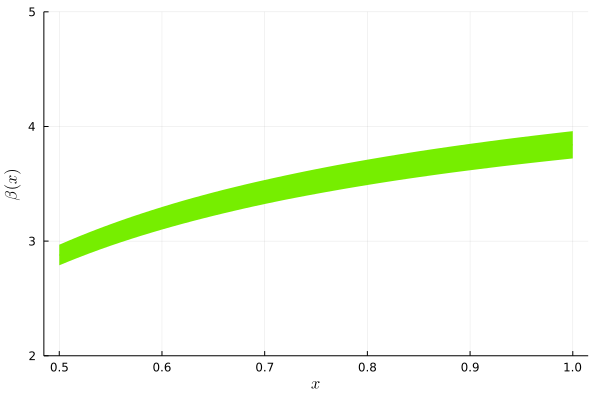

In [35]:
#
# Here we calculated the effective exponent of (1-x) for the u-valence distribution
#
x_range=0.5:0.01:1
f(v,x)=v.K_u-(1-x)*v.θ[1]*(v.K_u+1)/(2-v.θ[1])/x
plot(
   x_range, f, samples, yrange=(2,5),
   intervals = [0.68],
#   colors = [:green4],
   global_mode = false, median = false,
   label = L"68~\%~{\rm Credible \; Interval}",
    xlabel=L"x",
    ylabel=L"\beta(x)",
    legend=:none

)

In [36]:
savefig("EffExp.pdf")

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/f4aNp/src/algotypes/bat_default.jl:44


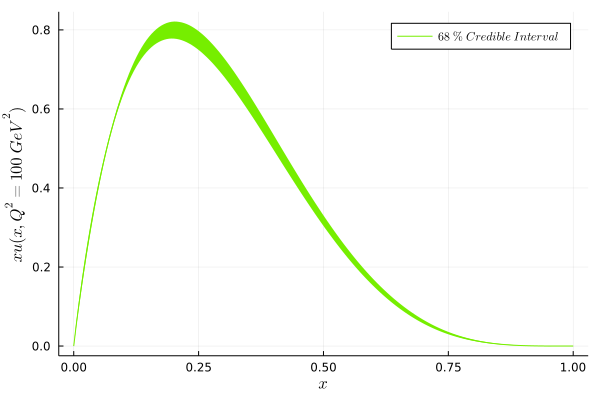

In [98]:
#
# And here the u-valence distribution itself
#
function wrap_xuVal(p::NamedTuple, x::Real)
    
    pdf_params3 = DirichletPDFParams(K_u=p.K_u, K_d=p.K_d, λ_g1=p.λ_g1, 
                                    λ_g2=p.λ_g2, K_g=p.K_g, λ_q=p.λ_q, θ=p.θ)
    uval = PartonDensity.x_uv_x(x,pdf_params3.λ_u,pdf_params3.K_u  )
    return uval
end
x_grid = range(0, stop=1, length=200)
plot(x_grid, wrap_xuVal, samples, intervals=[0.68],colors=[:chartreuse2],
   label = L"68~\%~{\rm Credible \; Interval}",
    xlabel=L"x",
    ylabel=L"xu(x,Q^2=100~{\rm GeV}^2)",
       global_mode = false, median = false,
    legend=:topright
)

In [39]:
savefig("xuvalence.pdf")

In [58]:
#
# Here we calculated the effective exponent of (1-x) for the u-valence distribution
#
f(v)=v.θ[1]*(v.K_u+1)/(2-v.θ[1])


f (generic function with 2 methods)

In [62]:
mode_pars_data = mode(samples)
f(mode_pars_data)

0.9679463250902894

In [97]:
sub_samples = BAT.bat_sample(samples, BAT.OrderedResampling(nsamples=10000)).result

lambda=zeros(10000)
for i=1:10000
    pdf_params_i = DirichletPDFParams(K_u=sub_samples.v.K_u[i], K_d=sub_samples.v.K_d[i],
                                          λ_g1=sub_samples.v.λ_g1[i], λ_g2=sub_samples.v.λ_g2[i],
                                          K_g=sub_samples.v.K_g[i], λ_q=sub_samples.v.λ_q[i], 
                                          θ=Vector(sub_samples.v.θ[i]))
    lambda[i]=f(pdf_params_i)
end
println(quantile!(lambda, 0.5)," ",quantile!(lambda, 0.16)," ",quantile!(lambda, 0.84))


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/f4aNp/src/algotypes/bat_default.jl:44


0.960505065534484 0.9188739228118309 1.000824008752299
